# Project: Predicting Credit Card Default

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

## Load Data

Load the data from csv file. It contains 15,000 records. Each record has these values:

**Response Variable：**
* Default or Not      

**Predictor Variables:**
1. Balance divided by credit limit.    
2. Age.                  
3. Number of times that 30-59 days past due.   
4. Debt divied by monthly income.                           
5. Monthly income.                 
6. Number of open credit lines and loans.        
7. Number of times that 90 and more days past due.              
8. Number of real estate loans.            
9. Number of times that 60-89 days past due.    
10. Number of dependents.

The goal of this project is to build a credit scoring model by predicting probability of credit default in the future.

In [3]:
import pandas as pd
df=pd.read_csv('./data/cs-training.csv', sep=',', index_col=0)
#print list(df.columns.values)
#print df.info() # basic information
#print data.describe() # basic statistics
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Preprocessing: 
### 1. Data distribution
#### 1.1. Q-Q plot

The quantile-quantile (q-q) plot is a graphical technique for determining if two data sets come from populations with a common distribution.

In [4]:
from scipy.stats import probplot
def qq_plot(x):
    probplot(x, dist='norm', plot=plt)

In [5]:
x=df['MonthlyIncome']
qq_plot(x[x<14000])

#### 1.2. KDE plot
In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample.

In [6]:
from scipy.stats.kde import gaussian_kde
def kde_plot(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    plt.plot(positions, smoothed)
    
def kde_values(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    return positions, smoothed

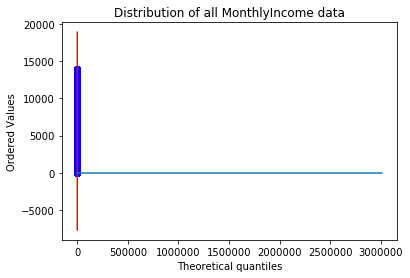

In [7]:
x=df['MonthlyIncome']
x=x.dropna()
kde_plot(x)
plt.title("Distribution of all MonthlyIncome data")
plt.show()

## Preprocessing: 
### 2. Outliers detection 
Set all values that are greater then 99 percentile be NaN.

In [8]:
print x.quantile(0.99), x.quantile(0.01)

25000.0 0.0


In [9]:
kde_plot(x[x<25000])
plt.title("Distribution of MonthlyIncome data which is less than 25,000")
plt.show

<function matplotlib.pyplot.show>

In [10]:
for col in range(1,11):
    m=df.iloc[:,col].dropna().quantile(0.99)
    df.iloc[:,col]=df.iloc[:,col].map(lambda x: None if x>m else x)

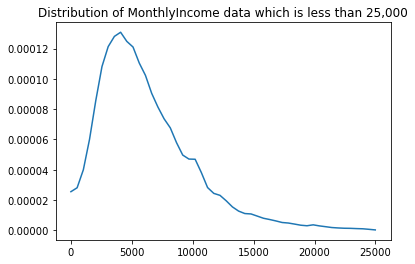

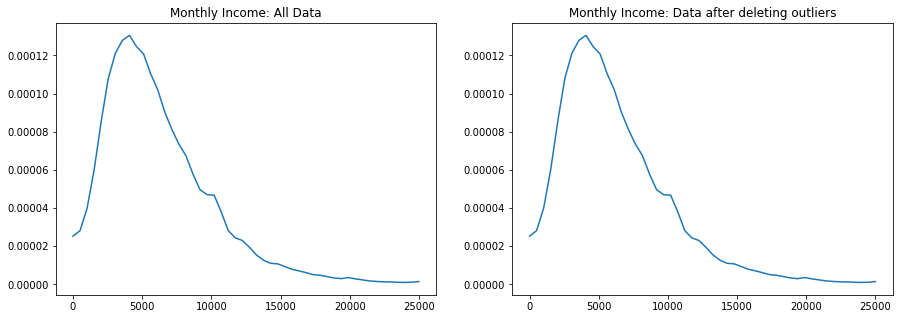

In [11]:
x=df['MonthlyIncome']
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Monthly Income: All Data')
positions, smoothed = kde_values(x[x<50000])
ax2.plot(positions, smoothed)
ax2.set_title('Monthly Income: Data after deleting outliers')
plt.show()

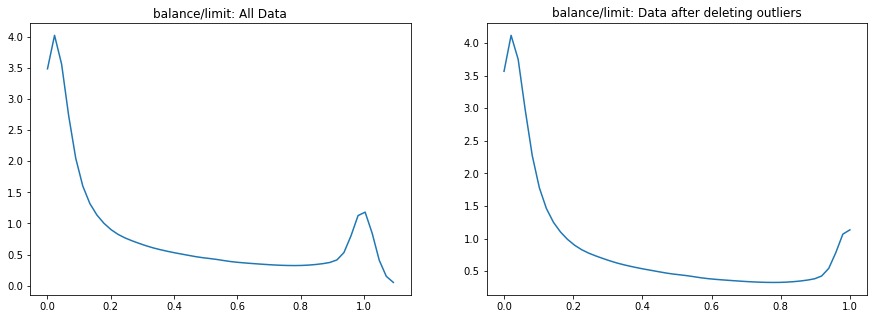

In [12]:
x=df.iloc[:,1] # balance/limit
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('balance/limit: All Data')
positions, smoothed = kde_values(x[x<1])
ax2.plot(positions, smoothed)
ax2.set_title('balance/limit: Data after deleting outliers')
plt.show()

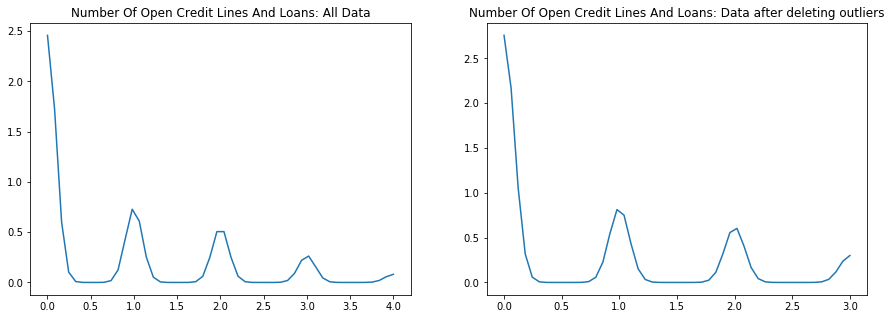

In [13]:
# NumberOfOpenCreditLinesAndLoans

x=df.iloc[:,10]
x=x.dropna()
m=x.quantile(0.99)

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Number Of Open Credit Lines And Loans: All Data')
positions, smoothed = kde_values(x[x<m])
ax2.plot(positions, smoothed)
ax2.set_title('Number Of Open Credit Lines And Loans: Data after deleting outliers')
plt.show()

# Preprocessing: 
### 3. Missing value
Replace all nan values as mean values.

In [14]:
y=df.iloc[:,0].fillna(df.mean()).as_matrix()
x=df.iloc[:,1:].fillna(df.mean()).as_matrix()
print y.shape
print x.shape

# from sklearn import preprocessing
# x = preprocessing.StandardScaler().fit_transform(x)

(150000,)
(150000, 10)


# Preprocessing: 
### Normalize

In [15]:
from sklearn import preprocessing
x = preprocessing.StandardScaler().fit_transform(x)

## Model Selection and Parameter Seaching
### 1. Grid Search and Cross Validation

In [16]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
tuned_parameters = {'criterion':["gini","entropy"]}
model = GridSearchCV(model,tuned_parameters,cv=5,verbose=1)
model.fit(x,y)
print model.best_params_
print model.best_score_ 

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
tuned_parameters = {'n_estimators':[10,20], 'max_depth':[None, 3]}
model = GridSearchCV(model,tuned_parameters,cv=3,verbose=1)
model.fit(x,y)
print model.best_params_
print model.best_score_ 

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier() 
tuned_parameters = {'n_estimators':[100,50], 'max_depth':[2, 3]}
model.fit(x,y)
model = GridSearchCV(model,tuned_parameters,cv=3,verbose=1)
model.fit(x,y)
print model.best_params_
print model.best_score_ 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


{'criterion': 'entropy'}
0.898766666667
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   22.2s finished


{'n_estimators': 10, 'max_depth': 3}
0.934326666667
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.4min finished


{'n_estimators': 50, 'max_depth': 3}
0.937093333333


# Put them in a for loop

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [DecisionTreeClassifier(), 
          RandomForestClassifier(), 
          GradientBoostingClassifier()]
tuned_parameters = [{'criterion':["gini","entropy"]},  # parameters for decision tree
                    {'n_estimators':[10,20], 'max_depth':[None, 3]}, # parameters for random forest
                   {'n_estimators':[100,50], 'max_depth':[2, 3]}] # parameters for gradient boosting 

# Higher score means a better model
for model, tuned_parameter in zip(models, tuned_parameters):
    classify = GridSearchCV(model,tuned_parameter,cv=5,verbose=1)
    classify.fit(x,y)
    print classify.best_params_
    print classify.best_score_ 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


{'criterion': 'entropy'}
0.89892
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.2s finished


{'n_estimators': 20, 'max_depth': None}
0.93434
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished


{'n_estimators': 100, 'max_depth': 3}
0.936773333333


## Evaluation
### 1. Accuracy Score

In [17]:
from sklearn.metrics import r2_score, accuracy_score

classify = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)
classify.fit(x,y)
yhat=classify.predict(x)
print accuracy_score(y,yhat) 

0.938013333333


### 2. ROC Area

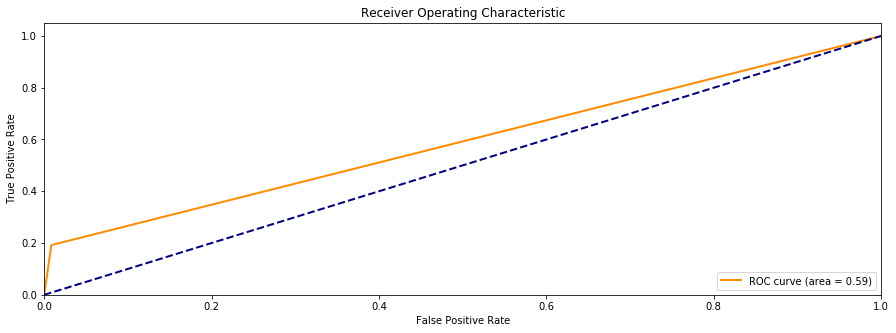

In [18]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, yhat)
roc_auc = auc(fpr, tpr)
    
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.axis('equal')
#plt.axis([0, 0.5, 0, 1])
plt.show()

# Plot feature importance

In [25]:
features= df.columns.values
value = classify.feature_importances_

ind=sorted(range(len(value)),reverse=False,key=lambda k: value[k])
features=features[ind]
value=sorted(value,reverse=False)
ind=np.array(range(10))
plt.rcParams['figure.figsize'] = (9,7)
plt.barh(bottom=ind,height=0.5,width=value,color='r')
plt.yticks(ind+0.25,features)
plt.xlabel('Weights')
plt.ylabel('Features')
plt.title('Feature Importances')
#plt.subplots_adjust(left=0.2)
plt.tight_layout()
#plt.savefig('feature_importances.png', format='png', dpi=300)
#plt.show()
plt.savefig('Feature_Importances.png', format='png', dpi=300)

# One hot Encoding
http://www.ritchieng.com/machinelearning-one-hot-encoding/

https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

classif_rate for DecisionTreeClassifier : 100.000000 
[ 0.  0.  0.  0.  0.  1.]


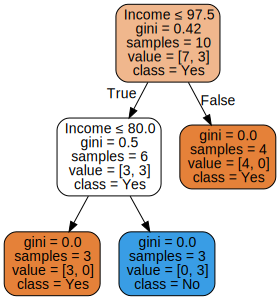

In [30]:
df = pd.DataFrame({"Refund" : ["Yes","No","No","Yes","No","No","Yes","No","No","No"],
                   "MartialStatus" : ["Single","Married","Single","Married","Divorced","Married","Divorced","Single","Married","Single"],
                   "Income" : [125,100,70,120,95,60,220,85,75,90],
                   "Cheat" : ["No","No","No","No","Yes","No","No","Yes","No","Yes"]})
df = df[["Refund","MartialStatus","Income","Cheat"]]

from sklearn.tree import DecisionTreeClassifier
x=df[["Refund","MartialStatus","Income"]].as_matrix()
y=df["Cheat"]

from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
le = preprocessing.LabelEncoder()
x_stringpart = x[:,:-1]
for i in range(2):
    x_stringpart[:,i] = le.fit_transform(x_stringpart[:,i])
enc.fit(x_stringpart)
x_stringpart=enc.transform(x_stringpart).toarray()
#print x, x_stringpart
x = np.c_[x_stringpart, x[:,-1]]

classify = DecisionTreeClassifier() # You can adjust some paraments here.
classify.fit(x,y)

y_pred = classify.predict(x)
classif_rate = np.mean(y_pred.ravel() == y.ravel()) * 100
print("classif_rate for %s : %f " % ('DecisionTreeClassifier', classif_rate))
print classify.feature_importances_

from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(classify, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

dot_data = tree.export_graphviz(classify, out_file=None, 
                         feature_names=["Refund-No","Refund-Yes", "Divorced","Single","Married","Income"],  
                         class_names=["Yes", "No"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 